## ONLY FOR TESTING! DO NOT GRADE!
Arathy Pillai, Alexander Guth, Hammad Akthar, Hiba Saleel and Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
from string import punctuation
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import variation

In [2]:
plot_size = plt.rcParams["figure.figsize"]  
plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

### Load data and determine na values
repost and Text are determined as na values, because they ... **[TODO]** ***Wichitg! Warum hier die Null weg oder drinne lassen??***

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '', 'Text', 'repost', 'r e p o s t -', 'Repost']

#na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)
#ira_data = ira_data[(ira_data['AD_IMPRESSIONS']> 0) & ira_data['AD_CLICKS'] > 0]

### Click per View Ratio
#Clicks / #Impressions

In [4]:
ira_data.insert(5, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

### Date operations
Get epoch time (ms since 01.01.1970)

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

def time_to_ms(dt):
    return dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1000 / 1000

In [6]:
ira_data['AD_CREATION_WEEKDAY'] = ira_data['AD_CREATION_DATE'].dt.dayofweek
ira_data['AD_CREATION_YEAR'] = ira_data['AD_CREATION_DATE'].dt.year
ira_data['AD_CREATION_MONTH'] = ira_data['AD_CREATION_DATE'].dt.month
ira_data['AD_CREATION_DAY'] = ira_data['AD_CREATION_DATE'].dt.day
ira_data['AD_CREATION_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: time_to_ms(x))
ira_data['AD_CREATION_EPOCH_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: unix_time_millis(x))

### Convert ruble
Removes "RUB" from the cell AD_SPEND

In [7]:
ira_data['AD_SPEND']=ira_data['AD_SPEND'].str.replace(' RUB','').astype('float')

### Drop all subsets, where AD_TEXT is na

In [8]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

3436

### Cleaning up Targeting Data

In [9]:
def remove_punctuation_at_the_end(x):
    #remove "," and "." and ":" from the end of x
    x = x.rstrip(',')
    x = x.rstrip('.')
    x = x.rstrip(':')
    #replace ";" and ",." with "," in x
    x = x.replace(';', ',')
    x = x.replace(',.', ',')
    return x

In [10]:
#replace abbreviations with their long form in AD_TARGETING_EXCLUDED_CONNECTIONS
ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS']=ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS'].str.replace('Exclude people who like BM','Exclude people who like Black Matters')

#replace ")or" (missing space) with ") or" and ");" with ")," in AD_TARGETING_LANGUAGE due to having a different formats used
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\)or', ') or')
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\);', '),')

#??Remove lines without AD_TARGETING_INTERESTS and execute remove_punctuation_at_the_end on each string in AD_TARGETING_INTERESTS
ira_data['AD_TARGETING_INTERESTS'] = ira_data['AD_TARGETING_INTERESTS'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'] = ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_EXCLUDE'] = ira_data['AD_TARGETING_EXCLUDE'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))

### Remove hyperlinks

In [11]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

***Remove hyperlinks***


In [12]:
ira_data['Duplicate'] = ira_data['AD_TEXT'].duplicated(keep=False)

In [13]:
#ira_data.hist();

### Remove Outliers ###

In [14]:
corrDf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME','Duplicate','AD_CREATION_DATE']].dropna()
std_dev = 3
corrDf = corrDf[(np.abs(stats.zscore(corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_SPEND']])) < float(std_dev)).all(axis=1)]

In [15]:
corrDf['AD_CLICKS_PER_VIEW'].count()

1600

### Flag all duplicate ad texts

In [16]:
ira_data['Duplicate'] = ira_data['AD_TEXT'].duplicated(keep=False)

### Total Duplicates

In [17]:
ira_data['AD_TEXT'].count()

3436

In [18]:
ira_data['Duplicate'].value_counts()

False    1998
True     1438
Name: Duplicate, dtype: int64

### Unique Duplicate Pairs

In [19]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].nunique()

361

### Occurence of Duplicate Pairs

In [20]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].value_counts().values

array([53, 23, 18, 16, 14, 14, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10,
       10, 10,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

In [21]:
ira_data[(ira_data['Duplicate'] == True) & ira_data['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_DATE', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME','AD_TEXT', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME']].head(20)

,AD_CLICKS,AD_IMPRESSIONS,AD_CREATION_DATE,AD_CREATION_WEEKDAY,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME,AD_TEXT,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME
AD_ID,,,,,,,,,,,,
580,103,122,2015-06-16 03:36:10,1,2015,6,16,12970.0,We speak for all fellow members of LGBT commun...,129.66,35000000.0,1.434426e+12
581,36,1438,2015-06-17 03:15:18,2,2015,6,17,11718.0,We speak for all fellow members of LGBT commun...,1362.57,144000000.0,1.434511e+12
582,1724,18891,2015-06-18 00:58:48,3,2015,6,18,3528.0,We speak for all fellow members of LGBT commun...,10085.77,35000000.0,1.434589e+12
583,186,4265,2015-06-22 08:19:07,0,2015,6,22,29947.0,We speak for all fellow members of LGBT commun...,1393.55,139000000.0,1.434961e+12
584,3206,31618,2015-06-23 05:06:57,1,2015,6,23,18417.0,We speak for all fellow members of LGBT commun...,16630.20,143000000.0,1.435036e+12
585,1252,11857,2015-07-01 02:55:07,2,2015,7,1,10507.0,We speak for all fellow members of LGBT commun...,5538.24,165000000.0,1.435719e+12
586,59,1811,2015-07-07 01:51:07,1,2015,7,7,6667.0,We speak for all fellow members of LGBT commun...,757.65,166000000.0,1.436234e+12
587,542,15175,2015-07-09 01:50:28,3,2015,7,9,6628.0,We speak for all fellow members of LGBT commun...,6201.70,35000000.0,1.436407e+12
588,21449,175460,2015-07-14 00:01:38,1,2015,7,14,98.0,We speak for all fellow members of LGBT commun...,93754.38,41000000.0,1.436832e+12


### Dealing with Missing Values

Multiple Imputation using MICE (Multiple Imputation by Chained Equations)

In [22]:
# https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e
#from fancyimpute import MICE
#ira_cols=list(ira_data)
#ira_data = pd.DataFrame(MICE(verbose=False).complete(ira_data))
#ira_data.columns = ira_cols

### Common Statistics
**[TODO]** Mean, median etc. for success --> Chart(?) ==> Alex

In [23]:
compair_AD_CLICKS = [[ira_data['AD_CLICKS'].count(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].count(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].count()],[ira_data['AD_CLICKS'].min(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].min(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].min()],[ira_data['AD_CLICKS'].max(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].max(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].max()],[ira_data['AD_CLICKS'].median(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].median(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].median()],[ira_data['AD_CLICKS'].mean(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].mean(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].mean()],[ira_data['AD_CLICKS'].std(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].std(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].std()],[ira_data['AD_CLICKS'].var(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].var(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].var()],[variation(ira_data['AD_CLICKS']),variation(ira_data['AD_CLICKS'][ira_data['Duplicate'] == True]),variation(ira_data['AD_CLICKS'][ira_data['Duplicate'] == False])]]
pd.DataFrame(compair_AD_CLICKS,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.6g}")

,All,Duplicates,Unique
Count,3436,1438,1998
Minimum,0,0,0
Maximum,73063,72043,73063
Median,66.5,0,223
Mean,1041.49,751.433,1250.25
Standard deviation,3359.29,3634.83,3130.43
Variance,1.12849e+07,1.3212e+07,9.79959e+06
Coefficient of variation,3.225,4.83552,2.50322


In [24]:
compair_AD_IMPRESSIONS = [[ira_data['AD_IMPRESSIONS'].count(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == True].count(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == False].count()],[ira_data['AD_IMPRESSIONS'].min(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == True].min(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == False].min()],[ira_data['AD_IMPRESSIONS'].max(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == True].max(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == False].max()],[ira_data['AD_IMPRESSIONS'].median(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == True].median(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == False].median()],[ira_data['AD_IMPRESSIONS'].mean(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == True].mean(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == False].mean()],[ira_data['AD_IMPRESSIONS'].std(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == True].std(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == False].std()],[ira_data['AD_IMPRESSIONS'].var(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == True].var(),ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == False].var()],[variation(ira_data['AD_IMPRESSIONS']),variation(ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == True]),variation(ira_data['AD_IMPRESSIONS'][ira_data['Duplicate'] == False])]]
pd.DataFrame(compair_AD_IMPRESSIONS,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.6g}")

,All,Duplicates,Unique
Count,3436,1438,1998
Minimum,0,0,0
Maximum,1.33454e+06,968768,1.33454e+06
Median,978.5,2.5,2890.5
Mean,11514.9,10568.6,12196
Standard deviation,45812.5,50885.4,41782
Variance,2.09878e+09,2.58933e+09,1.74574e+09
Coefficient of variation,3.97795,4.8131,3.42501


In [25]:
    compair_AD_CLICKS_PER_VIEW = [[ira_data['AD_CLICKS_PER_VIEW'].count(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == True].count(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == False].count()],[ira_data['AD_CLICKS_PER_VIEW'].min(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == True].min(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == False].min()],[ira_data['AD_CLICKS_PER_VIEW'].max(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == True].max(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == False].max()],[ira_data['AD_CLICKS_PER_VIEW'].median(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == True].median(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == False].median()],[ira_data['AD_CLICKS_PER_VIEW'].mean(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == True].mean(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == False].mean()],[ira_data['AD_CLICKS_PER_VIEW'].std(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == True].std(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == False].std()],[ira_data['AD_CLICKS_PER_VIEW'].var(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == True].var(),ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == False].var()],[variation(ira_data['AD_CLICKS_PER_VIEW']),variation(ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == True]),variation(ira_data['AD_CLICKS_PER_VIEW'][ira_data['Duplicate'] == False])]]
pd.DataFrame(compair_AD_CLICKS_PER_VIEW,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.6g}")

,All,Duplicates,Unique
Count,2533,742,1791
Minimum,0,0,0
Maximum,1.69079,0.844262,1.69079
Median,0.10099,0.0511875,0.119449
Mean,0.101251,0.0647432,0.116376
Standard deviation,0.078493,0.0681146,0.0775439
Variance,0.00616115,0.0046396,0.00601306
Coefficient of variation,nan,nan,nan


In [26]:
compair_AD_CLICKS_PER_VIEW = [[corrDf['AD_CLICKS_PER_VIEW'].count(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == True].count(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == False].count()],[corrDf['AD_CLICKS_PER_VIEW'].min(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == True].min(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == False].min()],[corrDf['AD_CLICKS_PER_VIEW'].max(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == True].max(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == False].max()],[corrDf['AD_CLICKS_PER_VIEW'].median(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == True].median(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == False].median()],[corrDf['AD_CLICKS_PER_VIEW'].mean(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == True].mean(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == False].mean()],[corrDf['AD_CLICKS_PER_VIEW'].std(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == True].std(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == False].std()],[corrDf['AD_CLICKS_PER_VIEW'].var(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == True].var(),corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == False].var()],[variation(corrDf['AD_CLICKS_PER_VIEW']),variation(corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == True]),variation(corrDf['AD_CLICKS_PER_VIEW'][corrDf['Duplicate'] == False])]]
pd.DataFrame(compair_AD_CLICKS_PER_VIEW,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.6g}")

,All,Duplicates,Unique
Count,1600,385,1215
Minimum,0,0,0
Maximum,0.306105,0.285714,0.306105
Median,0.114629,0.0638298,0.126577
Mean,0.107906,0.0728057,0.119028
Standard deviation,0.0637651,0.0584296,0.0613272
Variance,0.00406598,0.00341402,0.00376103
Coefficient of variation,0.590746,0.801499,0.51502


In [27]:
compair_AD_POTENTIAL_TARGET = [[ira_data['AD_POTENTIAL_TARGET'].count(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == True].count(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == False].count()],[ira_data['AD_POTENTIAL_TARGET'].min(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == True].min(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == False].min()],[ira_data['AD_POTENTIAL_TARGET'].max(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == True].max(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == False].max()],[ira_data['AD_POTENTIAL_TARGET'].median(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == True].median(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == False].median()],[ira_data['AD_POTENTIAL_TARGET'].mean(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == True].mean(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == False].mean()],[ira_data['AD_POTENTIAL_TARGET'].std(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == True].std(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == False].std()],[ira_data['AD_POTENTIAL_TARGET'].var(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == True].var(),ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == False].var()],[variation(ira_data['AD_POTENTIAL_TARGET']),variation(ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == True]),variation(ira_data['AD_POTENTIAL_TARGET'][ira_data['Duplicate'] == False])]]
pd.DataFrame(compair_AD_POTENTIAL_TARGET,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.6g}")

,All,Duplicates,Unique
Count,2292,904,1388
Minimum,1000,1000,1900
Maximum,2.53e+08,2.52e+08,2.53e+08
Median,1.7e+07,1.1e+07,2.4e+07
Mean,3.15229e+07,3.83993e+07,2.70442e+07
Standard deviation,4.71592e+07,6.3349e+07,3.17793e+07
Variance,2.22399e+15,4.01309e+15,1.00992e+15
Coefficient of variation,nan,nan,nan


In [28]:
compair_AD_POTENTIAL_TARGET = [[corrDf['AD_POTENTIAL_TARGET'].count(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == True].count(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == False].count()],[corrDf['AD_POTENTIAL_TARGET'].min(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == True].min(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == False].min()],[corrDf['AD_POTENTIAL_TARGET'].max(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == True].max(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == False].max()],[corrDf['AD_POTENTIAL_TARGET'].median(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == True].median(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == False].median()],[corrDf['AD_POTENTIAL_TARGET'].mean(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == True].mean(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == False].mean()],[corrDf['AD_POTENTIAL_TARGET'].std(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == True].std(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == False].std()],[corrDf['AD_POTENTIAL_TARGET'].var(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == True].var(),corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == False].var()],[variation(corrDf['AD_POTENTIAL_TARGET']),variation(corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == True]),variation(corrDf['AD_POTENTIAL_TARGET'][corrDf['Duplicate'] == False])]]
pd.DataFrame(compair_AD_POTENTIAL_TARGET,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.10g}")

,All,Duplicates,Unique
Count,1600,385,1215
Minimum,1900,29000,1900
Maximum,144000000,144000000,136000000
Median,23000000,17000000,24000000
Mean,23628912.44,23077316.88,23803697.86
Standard deviation,21749451.51,28044694.65,19342926.47
Variance,4.730386408e+14,7.865048981e+14,3.741488043e+14
Coefficient of variation,0.920171582,1.213670091,0.8122672741


In [29]:
compair_AD_SPEND = [[ira_data['AD_SPEND'].count(),ira_data['AD_SPEND'][ira_data['Duplicate'] == True].count(),ira_data['AD_SPEND'][ira_data['Duplicate'] == False].count()],[ira_data['AD_SPEND'].min(),ira_data['AD_SPEND'][ira_data['Duplicate'] == True].min(),ira_data['AD_SPEND'][ira_data['Duplicate'] == False].min()],[ira_data['AD_SPEND'].max(),ira_data['AD_SPEND'][ira_data['Duplicate'] == True].max(),ira_data['AD_SPEND'][ira_data['Duplicate'] == False].max()],[ira_data['AD_SPEND'].median(),ira_data['AD_SPEND'][ira_data['Duplicate'] == True].median(),ira_data['AD_SPEND'][ira_data['Duplicate'] == False].median()],[ira_data['AD_SPEND'].mean(),ira_data['AD_SPEND'][ira_data['Duplicate'] == True].mean(),ira_data['AD_SPEND'][ira_data['Duplicate'] == False].mean()],[ira_data['AD_SPEND'].std(),ira_data['AD_SPEND'][ira_data['Duplicate'] == True].std(),ira_data['AD_SPEND'][ira_data['Duplicate'] == False].std()],[ira_data['AD_SPEND'].var(),ira_data['AD_SPEND'][ira_data['Duplicate'] == True].var(),ira_data['AD_SPEND'][ira_data['Duplicate'] == False].var()],[variation(ira_data['AD_SPEND']),variation(ira_data['AD_SPEND'][ira_data['Duplicate'] == True]),variation(ira_data['AD_SPEND'][ira_data['Duplicate'] == False])]]
pd.DataFrame(compair_AD_SPEND,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.6g}")

,All,Duplicates,Unique
Count,2655,810,1845
Minimum,0,0,0
Maximum,331676,331676,110588
Median,300,400,300
Mean,2205.61,4762.12,1083.24
Standard deviation,10316.1,16881.8,4899.36
Variance,1.06421e+08,2.84995e+08,2.40038e+07
Coefficient of variation,nan,nan,nan


In [30]:
compair_AD_SPEND = [[corrDf['AD_SPEND'].count(),corrDf['AD_SPEND'][corrDf['Duplicate'] == True].count(),corrDf['AD_SPEND'][corrDf['Duplicate'] == False].count()],[corrDf['AD_SPEND'].min(),corrDf['AD_SPEND'][corrDf['Duplicate'] == True].min(),corrDf['AD_SPEND'][corrDf['Duplicate'] == False].min()],[corrDf['AD_SPEND'].max(),corrDf['AD_SPEND'][corrDf['Duplicate'] == True].max(),corrDf['AD_SPEND'][corrDf['Duplicate'] == False].max()],[corrDf['AD_SPEND'].median(),corrDf['AD_SPEND'][corrDf['Duplicate'] == True].median(),corrDf['AD_SPEND'][corrDf['Duplicate'] == False].median()],[corrDf['AD_SPEND'].mean(),corrDf['AD_SPEND'][corrDf['Duplicate'] == True].mean(),corrDf['AD_SPEND'][corrDf['Duplicate'] == False].mean()],[corrDf['AD_SPEND'].std(),corrDf['AD_SPEND'][corrDf['Duplicate'] == True].std(),corrDf['AD_SPEND'][corrDf['Duplicate'] == False].std()],[corrDf['AD_SPEND'].var(),corrDf['AD_SPEND'][corrDf['Duplicate'] == True].var(),corrDf['AD_SPEND'][corrDf['Duplicate'] == False].var()],[variation(corrDf['AD_SPEND']),variation(corrDf['AD_SPEND'][corrDf['Duplicate'] == True]),variation(corrDf['AD_SPEND'][corrDf['Duplicate'] == False])]]
pd.DataFrame(compair_AD_SPEND,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.6g}")

,All,Duplicates,Unique
Count,1600,385,1215
Minimum,0,0,0
Maximum,39054.4,39054.4,26488.2
Median,300,500,300
Mean,1192.03,2852.48,665.883
Standard deviation,3597.67,6201.38,1931.88
Variance,1.29432e+07,3.84571e+07,3.73215e+06
Coefficient of variation,3.01715,2.1712,2.90003


In [31]:
corrDf['AD_CREATION_YEAR'].median()

2016.0

In [58]:
corrDf['AD_CREATION_EPOCH_TIME'].median()

1481067047500.0

In [62]:
only2015 = corrDf.loc[corrDf['AD_CREATION_YEAR'] == 2016]
only2015['AD_CREATION_YEAR'].count()

785

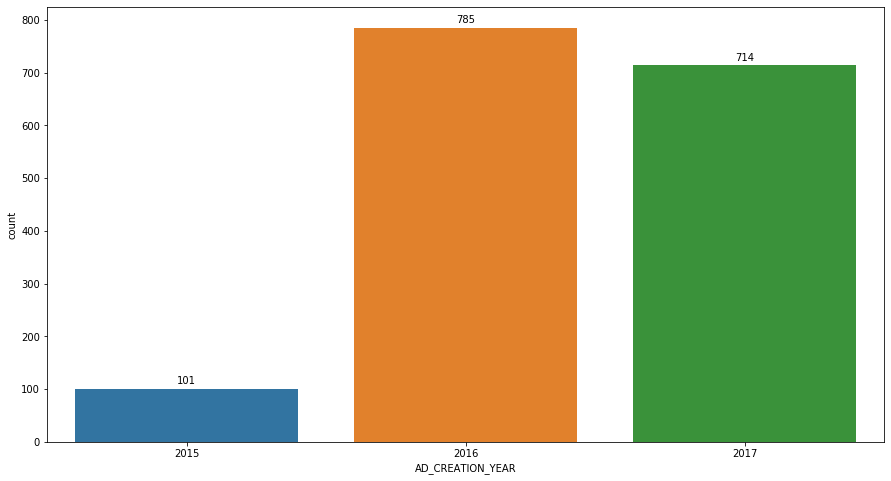

In [65]:


ax = sns.countplot(x="AD_CREATION_YEAR", data=corrDf)
#Adding values on top of each bar
rects = ax.patches
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, rect.get_height(),
            ha='center', va='bottom')
# X-axis labels
#labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' , 'Saturday' , 'Sunday']
#ax = ax.set_xticklabels(labels)


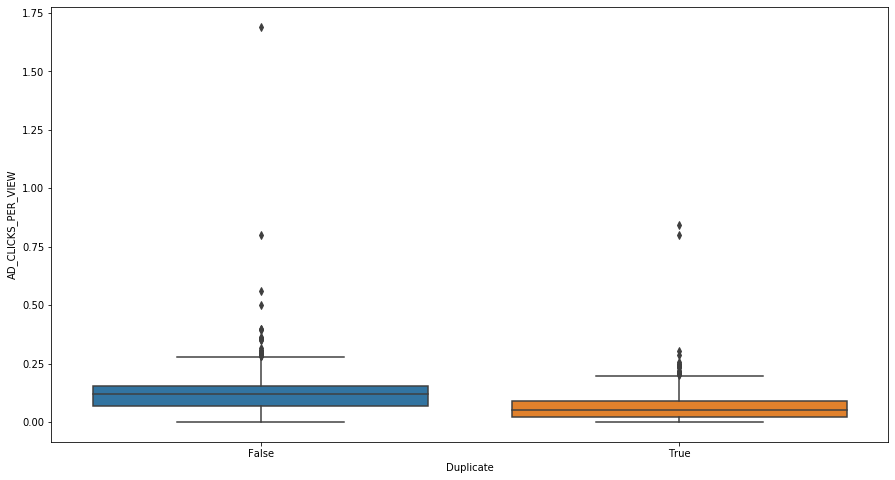

In [32]:
ax = sns.boxplot(x="Duplicate", y="AD_CLICKS_PER_VIEW", data=ira_data)

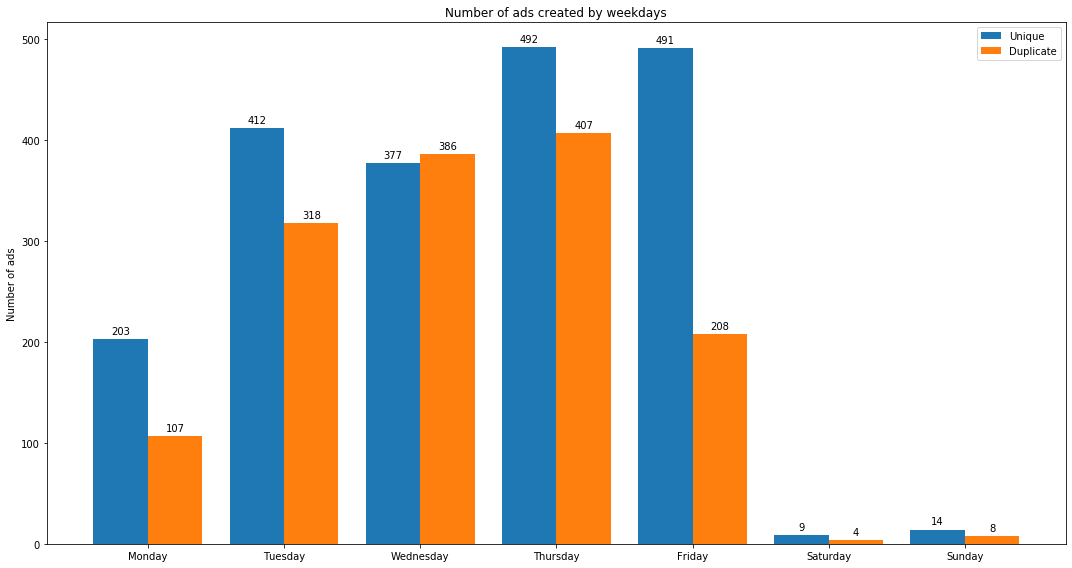

In [33]:
duplicateAdsPerWeekday = ira_data[ira_data['Duplicate'] == True].groupby(['AD_CREATION_WEEKDAY'])['AD_CLICKS'].count()
uniqueAdsPerWeekday = ira_data[ira_data['Duplicate'] == False].groupby(['AD_CREATION_WEEKDAY'])['AD_CLICKS'].count()

labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' , 'Saturday' , 'Sunday']
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, uniqueAdsPerWeekday, width, label='Unique')
rects2 = ax.bar(x + width/2, duplicateAdsPerWeekday, width, label='Duplicate')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of ads')
ax.set_title('Number of ads created by weekdays')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()


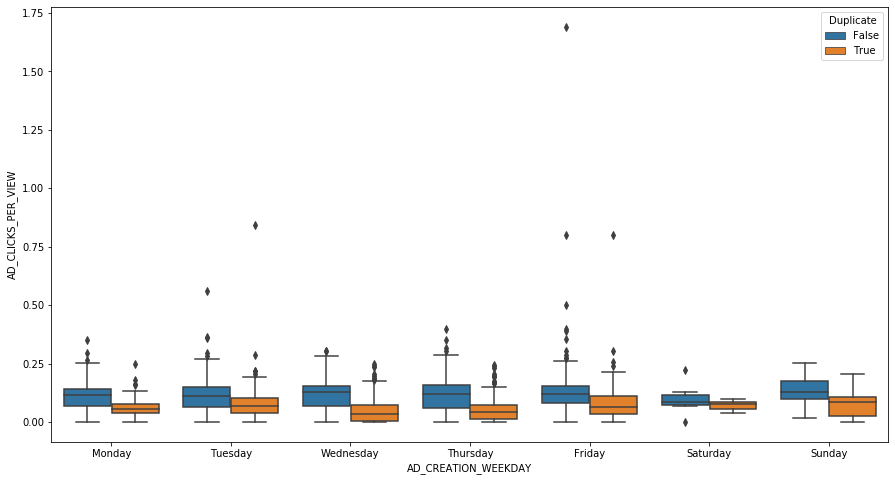

In [34]:
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' , 'Saturday' , 'Sunday']
ax = sns.boxplot(x="AD_CREATION_WEEKDAY", y="AD_CLICKS_PER_VIEW", hue='Duplicate', data=ira_data).set_xticklabels(labels)


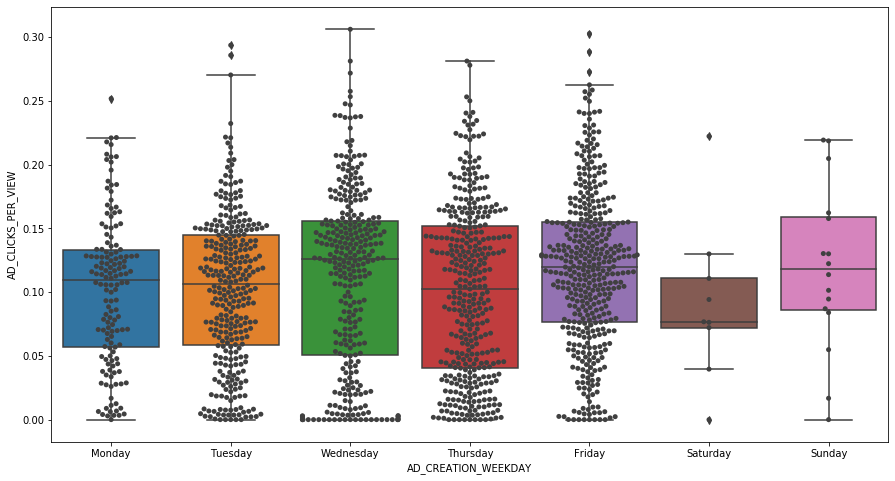

In [35]:
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' , 'Saturday' , 'Sunday']
ax = sns.boxplot(x="AD_CREATION_WEEKDAY", y="AD_CLICKS_PER_VIEW", data=corrDf)
ax = sns.swarmplot(x="AD_CREATION_WEEKDAY", y="AD_CLICKS_PER_VIEW", data=corrDf, color=".25").set_xticklabels(labels)
plt.savefig(r"../Images/Boxplot_SwarmPlot_AD_CREATION_WEEKDAY_AD_CLICKS_PER_VIEW.png",dpi=600)

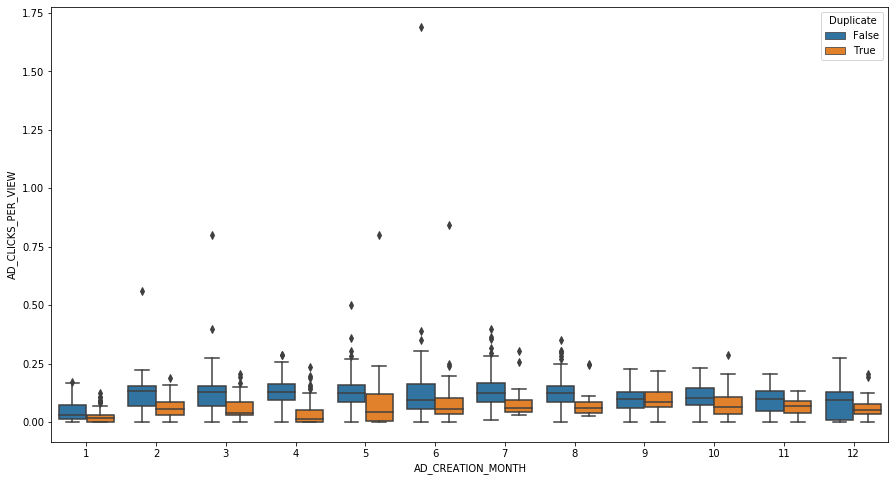

In [36]:
ax = sns.boxplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", hue='Duplicate', data=ira_data)


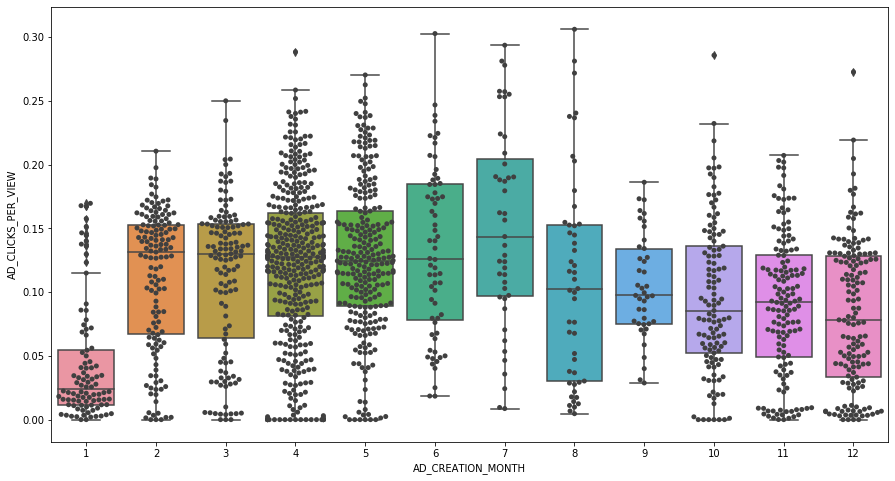

In [37]:
ax = sns.boxplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=corrDf)
ax = sns.swarmplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=corrDf, color=".25")
plt.savefig(r"../Images/Boxplot_SwarmPlot_AD_CREATION_MONTH_AD_CLICKS_PER_VIEW.png",dpi=600)


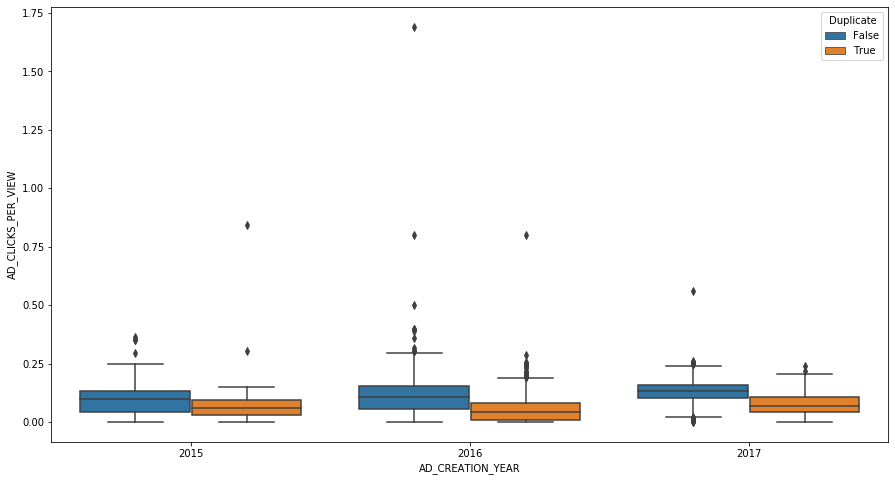

In [38]:
ax = sns.boxplot(x="AD_CREATION_YEAR", y="AD_CLICKS_PER_VIEW", hue='Duplicate', data=ira_data)


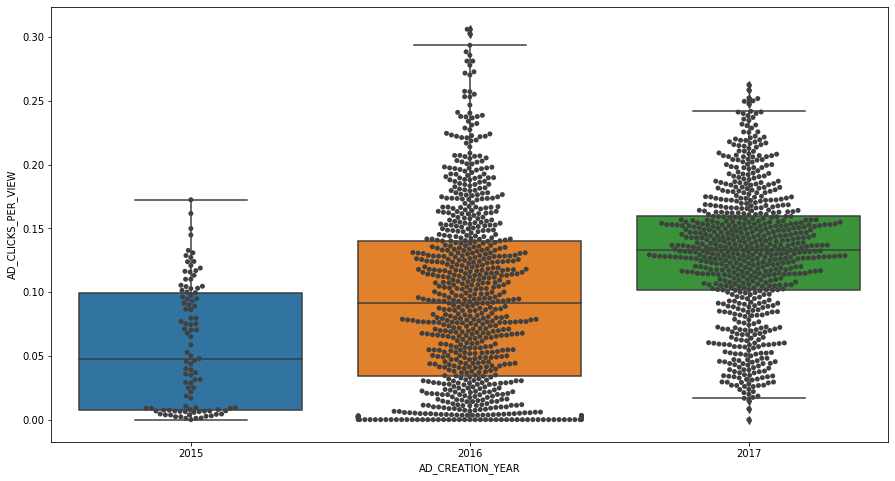

In [39]:
ax = sns.boxplot(x="AD_CREATION_YEAR", y="AD_CLICKS_PER_VIEW", data=corrDf)
ax = sns.swarmplot(x="AD_CREATION_YEAR", y="AD_CLICKS_PER_VIEW", data=corrDf, color=".25")
plt.savefig(r"../Images/Boxplot_SwarmPlot_AD_CREATION_YEAR_AD_CLICKS_PER_VIEW.png",dpi=600)



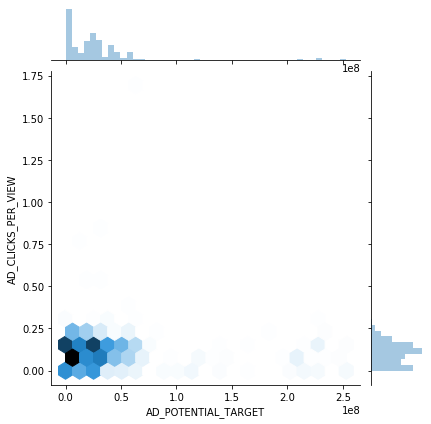

In [40]:
ax = sns.jointplot(x='AD_POTENTIAL_TARGET', y='AD_CLICKS_PER_VIEW', data=ira_data, kind='hex', gridsize=20)



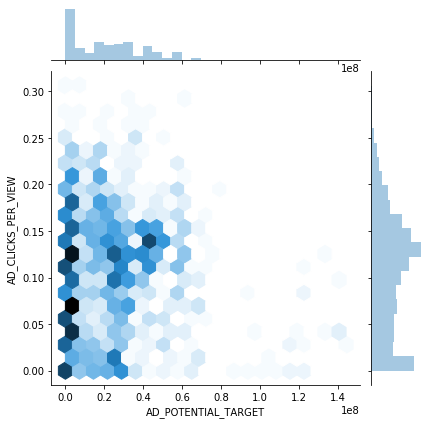

In [41]:
ax = sns.jointplot(x='AD_POTENTIAL_TARGET', y='AD_CLICKS_PER_VIEW', data=corrDf, kind='hex', gridsize=20)
plt.savefig(r"../Images/Jointplot_AD_POTENTIAL_TARGET_AD_CLICKS_PER_VIEW.png",dpi=600)


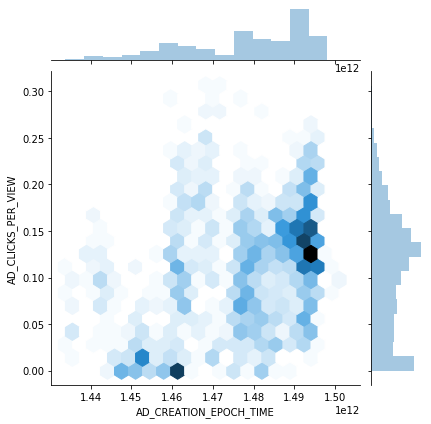

In [42]:
ax = sns.jointplot(x='AD_CREATION_EPOCH_TIME', y='AD_CLICKS_PER_VIEW', data=corrDf, kind='hex', gridsize=20)

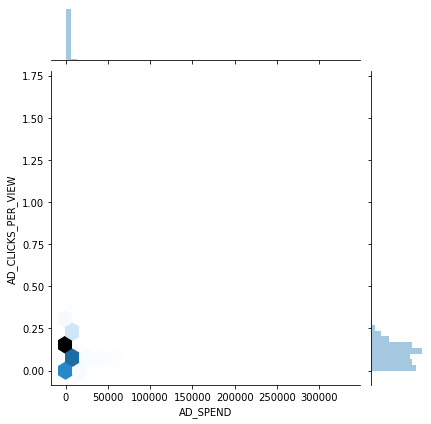

In [43]:
ax = sns.jointplot(x='AD_SPEND', y='AD_CLICKS_PER_VIEW', data=ira_data, kind='hex', gridsize=20)
#plt.savefig(r"../Images/Jointplot_AD_SPEND_AD_CLICKS_PER_VIEW.png",dpi=600)



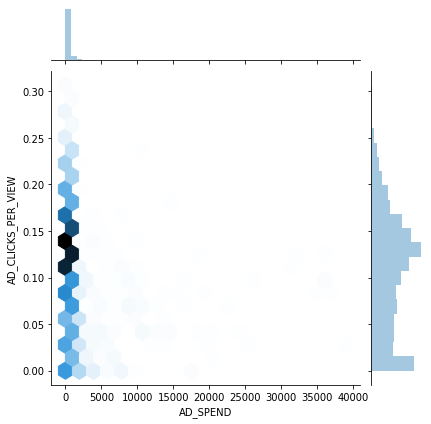

In [44]:
ax = sns.jointplot(x='AD_SPEND', y='AD_CLICKS_PER_VIEW', data=corrDf, kind='hex', gridsize=20)


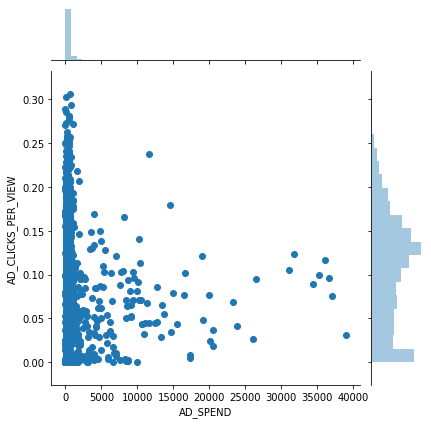

In [45]:
ax = sns.jointplot(x='AD_SPEND', y='AD_CLICKS_PER_VIEW', data=corrDf)
plt.savefig(r"../Images/Jointplot_AD_SPEND_AD_CLICKS_PER_VIEW.png",dpi=600)

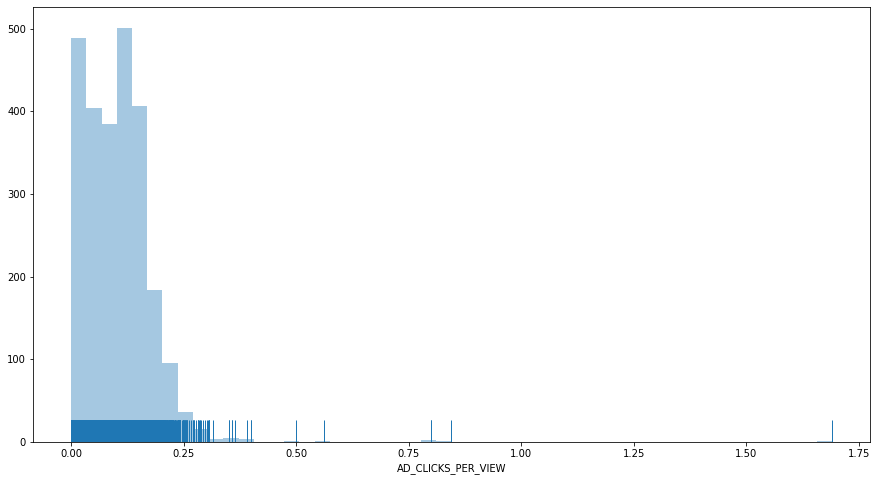

In [46]:
sns.distplot(ira_data.dropna(subset=['AD_CLICKS_PER_VIEW'])['AD_CLICKS_PER_VIEW'], kde=False, rug=True);

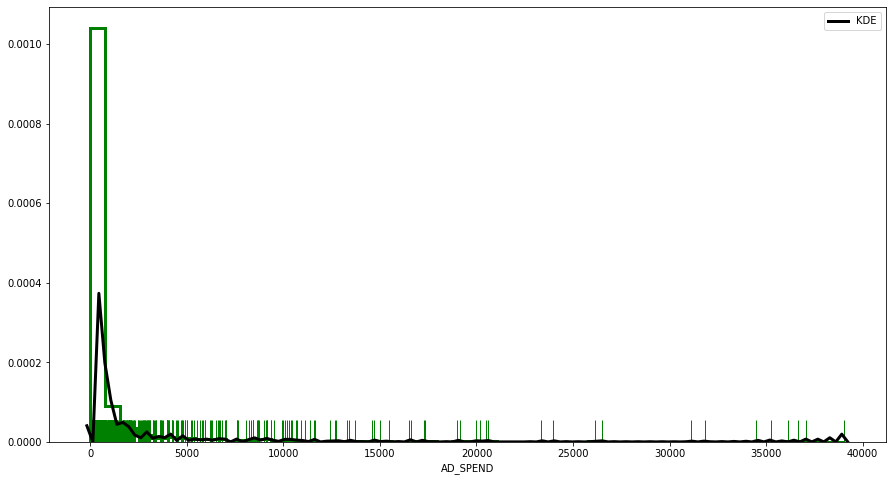

In [47]:
ax = sns.distplot(corrDf['AD_SPEND'], rug=True, rug_kws={"color": "g"},
...                   kde_kws={"color": "k", "lw": 3, "label": "KDE"},
...                   hist_kws={"histtype": "step", "linewidth": 3,
...                             "alpha": 1, "color": "g"})

### Correlations
**TODO** Handling of Outliers?, beautify the plot (axis labels, etc.), correlation of time

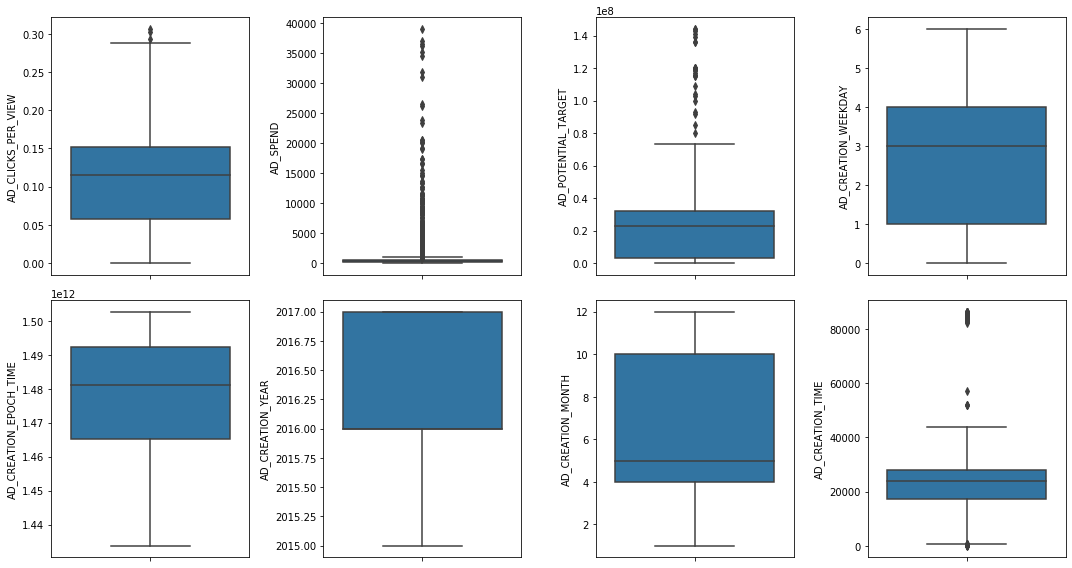

In [48]:
fig, axs = plt.subplots(2,4)

sns.boxplot(y="AD_CLICKS_PER_VIEW", data=corrDf, ax=axs[0][0])
#sns.swarmplot(y="AD_CLICKS_PER_VIEW", data=corrDf, color=".25", ax=axs[0])
sns.boxplot(y="AD_SPEND", data=corrDf, ax=axs[0][1])
#sns.swarmplot(y="AD_SPEND", data=corrDf, color=".25", ax=axs[1])
sns.boxplot(y="AD_POTENTIAL_TARGET", data=corrDf, ax=axs[0][2])
#
sns.boxplot(y="AD_CREATION_WEEKDAY", data=corrDf, ax=axs[0][3])
#
sns.boxplot(y="AD_CREATION_EPOCH_TIME", data=corrDf, ax=axs[1][0])
#
sns.boxplot(y="AD_CREATION_YEAR", data=corrDf, ax=axs[1][1])
#
sns.boxplot(y="AD_CREATION_MONTH", data=corrDf, ax=axs[1][2])
#
sns.boxplot(y="AD_CREATION_TIME", data=corrDf, ax=axs[1][3])
fig.tight_layout() 
plt.savefig(r"../Images/Boxplot_overview_withoutswarm.png",dpi=600)

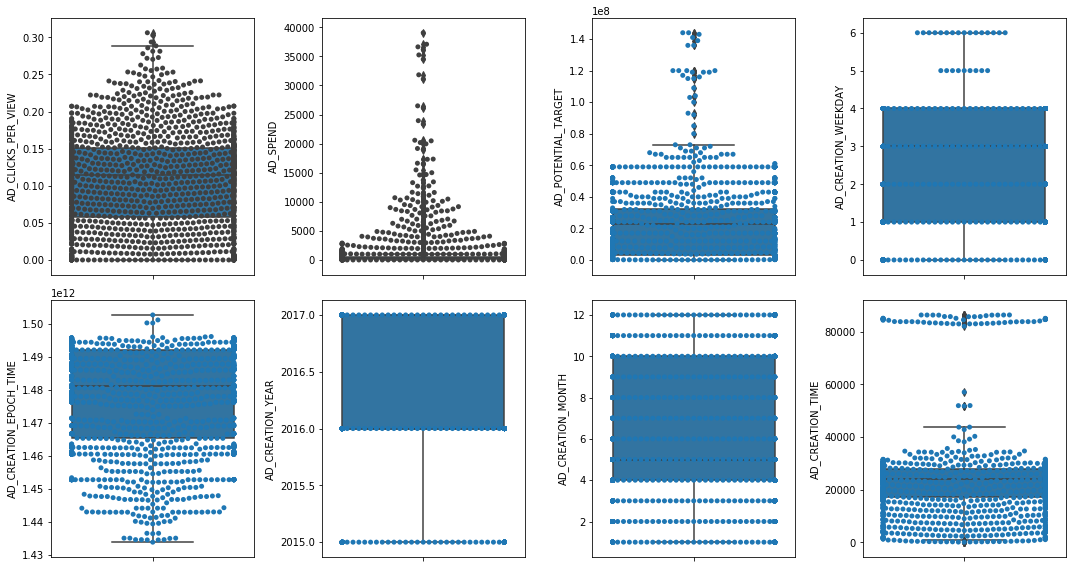

In [49]:
fig, axs = plt.subplots(2,4)

sns.boxplot(y="AD_CLICKS_PER_VIEW", data=corrDf, ax=axs[0][0])
sns.swarmplot(y="AD_CLICKS_PER_VIEW", data=corrDf, color=".25", ax=axs[0][0])
sns.boxplot(y="AD_SPEND", data=corrDf, ax=axs[0][1])
sns.swarmplot(y="AD_SPEND", data=corrDf, color=".25", ax=axs[0][1])
sns.boxplot(y="AD_POTENTIAL_TARGET", data=corrDf, ax=axs[0][2])
sns.swarmplot(y="AD_POTENTIAL_TARGET", data=corrDf, ax=axs[0][2])
sns.boxplot(y="AD_CREATION_WEEKDAY", data=corrDf, ax=axs[0][3])
sns.swarmplot(y="AD_CREATION_WEEKDAY", data=corrDf, ax=axs[0][3])
sns.boxplot(y="AD_CREATION_EPOCH_TIME", data=corrDf, ax=axs[1][0])
sns.swarmplot(y="AD_CREATION_EPOCH_TIME", data=corrDf, ax=axs[1][0])
sns.boxplot(y="AD_CREATION_YEAR", data=corrDf, ax=axs[1][1])
sns.swarmplot(y="AD_CREATION_YEAR", data=corrDf, ax=axs[1][1])
sns.boxplot(y="AD_CREATION_MONTH", data=corrDf, ax=axs[1][2])
sns.swarmplot(y="AD_CREATION_MONTH", data=corrDf, ax=axs[1][2])
sns.boxplot(y="AD_CREATION_TIME", data=corrDf, ax=axs[1][3])
sns.swarmplot(y="AD_CREATION_TIME", data=corrDf, ax=axs[1][3])
fig.tight_layout() 
plt.savefig(r"../Images/Boxplot_overview.png",dpi=600)


In [50]:
corrDf['AD_CREATION_DATE'].max()

Timestamp('2017-08-13 22:47:48')

In [51]:
compair_AD_CLICKS = [[ira_data['AD_CLICKS'].count(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].count(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].count()],[ira_data['AD_CLICKS'].min(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].min(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].min()],[ira_data['AD_CLICKS'].max(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].max(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].max()],[ira_data['AD_CLICKS'].median(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].median(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].median()],[ira_data['AD_CLICKS'].mean(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].mean(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].mean()],[ira_data['AD_CLICKS'].std(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].std(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].std()],[ira_data['AD_CLICKS'].var(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == True].var(),ira_data['AD_CLICKS'][ira_data['Duplicate'] == False].var()],[variation(ira_data['AD_CLICKS']),variation(ira_data['AD_CLICKS'][ira_data['Duplicate'] == True]),variation(ira_data['AD_CLICKS'][ira_data['Duplicate'] == False])]]
pd.DataFrame(compair_AD_CLICKS,columns=["All", "Duplicates","Unique"], index=["Count","Minimum","Maximum","Median","Mean","Standard deviation","Variance", "Coefficient of variation"]).style.format("{:.6g}")

,All,Duplicates,Unique
Count,3436,1438,1998
Minimum,0,0,0
Maximum,73063,72043,73063
Median,66.5,0,223
Mean,1041.49,751.433,1250.25
Standard deviation,3359.29,3634.83,3130.43
Variance,1.12849e+07,1.3212e+07,9.79959e+06
Coefficient of variation,3.225,4.83552,2.50322


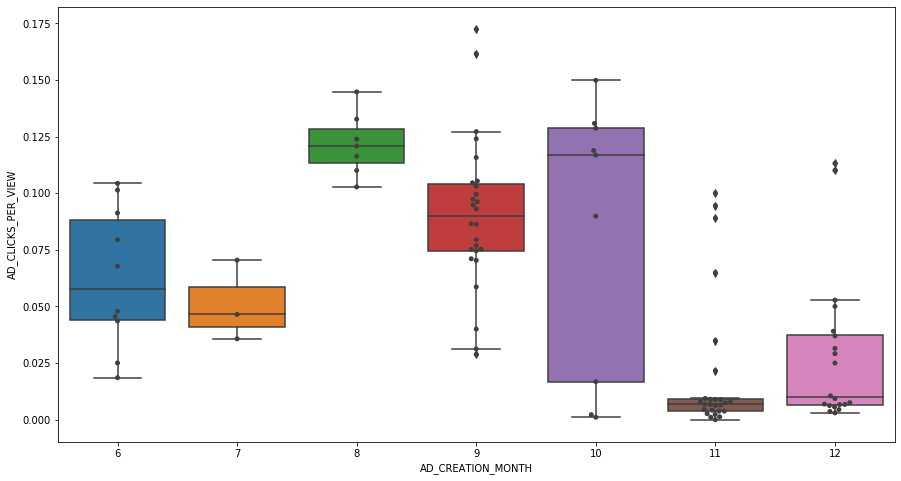

In [52]:
only2015 = corrDf.loc[corrDf['AD_CREATION_YEAR'] == 2015]
ax = sns.boxplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=only2015)
ax = sns.swarmplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=only2015, color=".25")

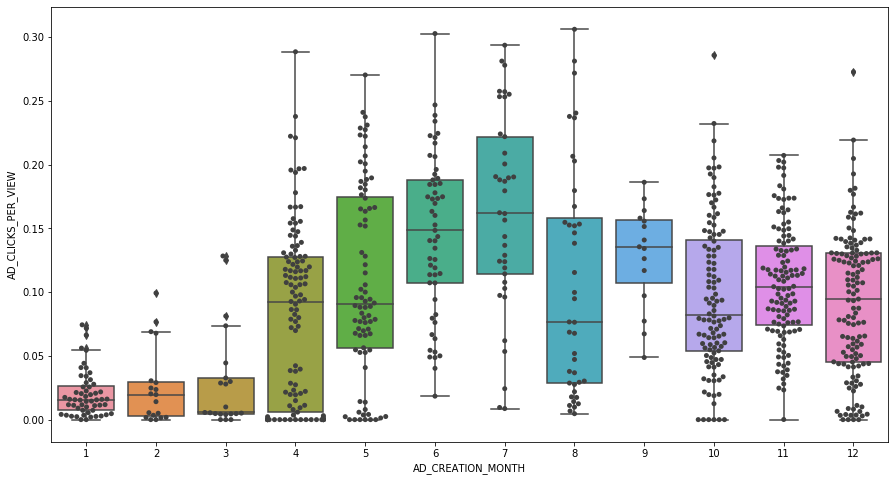

In [53]:
only2016 = corrDf.loc[corrDf['AD_CREATION_YEAR'] == 2016]
ax = sns.boxplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=only2016)
ax = sns.swarmplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=only2016, color=".25")

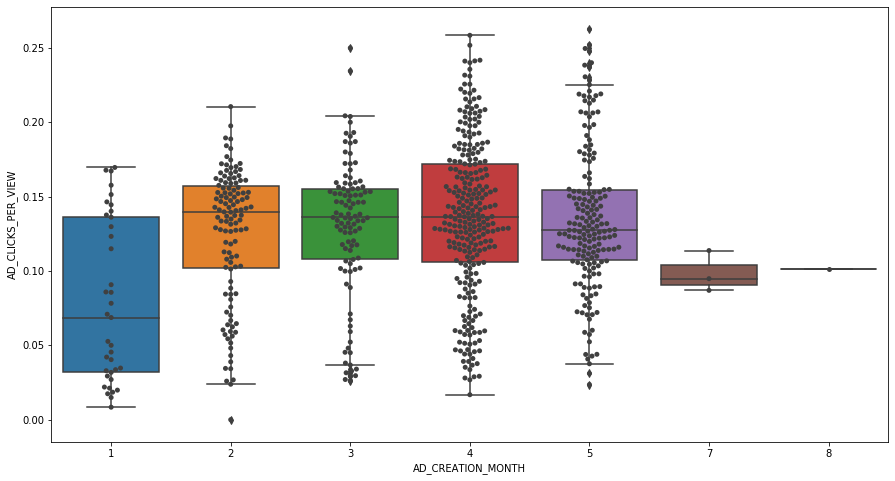

In [54]:
only2017 = corrDf.loc[corrDf['AD_CREATION_YEAR'] == 2017]
ax = sns.boxplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=only2017)
ax = sns.swarmplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=only2017, color=".25")

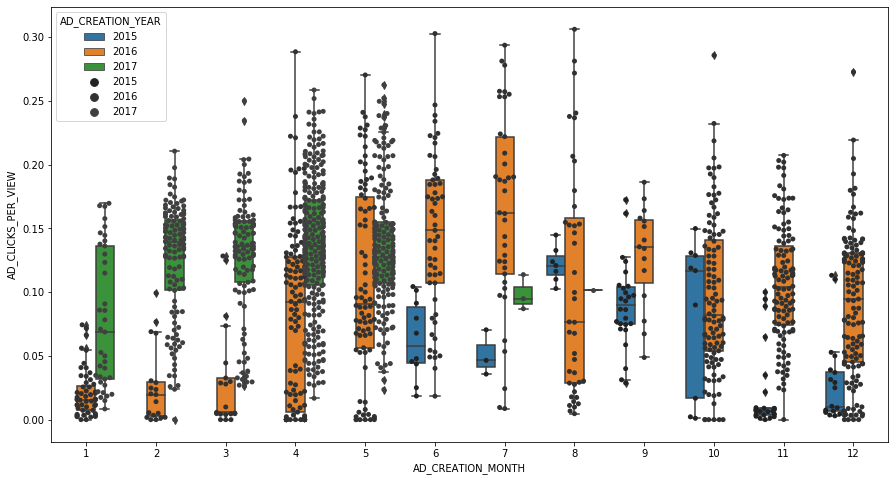

In [55]:
all = corrDf
ax = sns.boxplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=all, hue='AD_CREATION_YEAR')
ax = sns.swarmplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", data=all, color=".25", hue='AD_CREATION_YEAR', dodge=True)

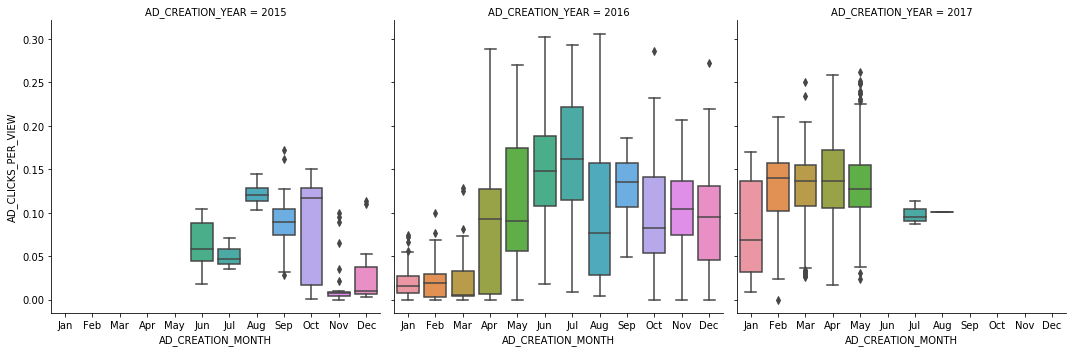

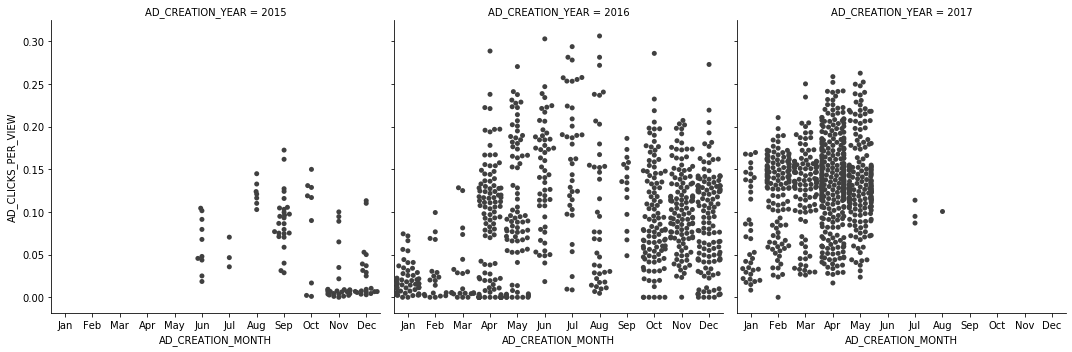

In [56]:
labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug", "Sep", "Oct", "Nov", "Dec"]

ax = sns.catplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", col="AD_CREATION_YEAR", data=all, kind="box").set_xticklabels(labels)
ax = sns.catplot(x="AD_CREATION_MONTH", y="AD_CLICKS_PER_VIEW", col="AD_CREATION_YEAR", data=all, kind="swarm", color=".25").set_xticklabels(labels)


In [57]:
corrDf['AD_CREATION_YEAR'].median()

2016.0